In [1]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time

In [102]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [103]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка данных

In [105]:
BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.',
                                    split='letters',
                                  train=True,
                                  transform =transforms,
                                  download=True)
test_dataset = tv.datasets.EMNIST('.',
                                 split='letters',
                                 train=False,
                                 transform =transforms,
                                 download=True)


train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [9]:
train_dataset.classes

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [11]:
len(test_dataset.classes)

27

In [13]:
symbol = { item:test_dataset.classes[item] for item in range(0,len(test_dataset.classes) , 1)}
symbol

{0: 'N/A',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [24]:
x, y = train_dataset[25]
print(symbol[y])

u


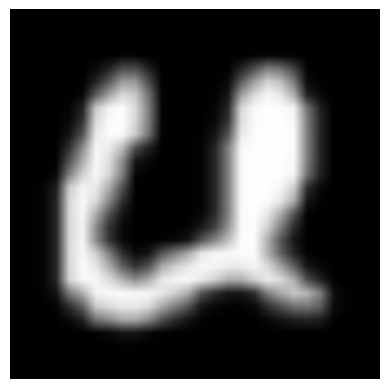

In [25]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow( x.permute(2, 1, 0)   )
plt.show()

## ResNet 18

In [29]:
model = tv.models.resnet18(pretrained=True)

from torchsummary import summary
summary(model, input_size=(3, 224, 224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [30]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
for param in model.parameters():
    param.requires_grad = False

In [34]:
model.fc = nn.Linear(in_features=512, out_features=27)

In [35]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [36]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 2.704. Train acc: 0.035. Train Loss: 3.470
Step 10. time since epoch: 5.320. Train acc: 0.185. Train Loss: 3.601
Step 20. time since epoch: 7.883. Train acc: 0.325. Train Loss: 2.831
Step 30. time since epoch: 10.446. Train acc: 0.409. Train Loss: 2.373
Step 40. time since epoch: 13.019. Train acc: 0.474. Train Loss: 2.065
Step 50. time since epoch: 15.587. Train acc: 0.519. Train Loss: 1.863
Step 60. time since epoch: 18.143. Train acc: 0.553. Train Loss: 1.710
Step 70. time since epoch: 20.713. Train acc: 0.580. Train Loss: 1.591
Step 80. time since epoch: 23.275. Train acc: 0.602. Train Loss: 1.492
Step 90. time since epoch: 25.850. Train acc: 0.620. Train Loss: 1.413
Step 100. time since epoch: 28.423. Train acc: 0.635. Train Loss: 1.348
Step 110. time since epoch: 30.998. Train acc: 0.646. Train Loss: 1.293
Step 120. time since epoch: 33.584. Train acc: 0.656. Train Loss: 1.248
Step 130. time since epoch: 36.180. Train acc: 0.666. Train Loss: 1.206
Step 1

## VGG 16

In [37]:
model = tv.models.vgg16(pretrained=True)

D:\Study\netology\module_1\pythonProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\daimond025/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:25<00:00, 21.5MB/s] 


In [38]:
summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [39]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
for param in model.parameters():
    param.requires_grad = False

In [41]:
model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [43]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=27)

In [44]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [45]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 1.900. Train acc: 0.047. Train Loss: 3.331
Step 10. time since epoch: 15.127. Train acc: 0.241. Train Loss: 3.511
Step 20. time since epoch: 28.360. Train acc: 0.335. Train Loss: 2.817
Step 30. time since epoch: 41.540. Train acc: 0.396. Train Loss: 2.455
Step 40. time since epoch: 54.717. Train acc: 0.435. Train Loss: 2.222
Step 50. time since epoch: 67.895. Train acc: 0.463. Train Loss: 2.066
Step 60. time since epoch: 81.072. Train acc: 0.483. Train Loss: 1.950
Step 70. time since epoch: 94.264. Train acc: 0.500. Train Loss: 1.865
Step 80. time since epoch: 107.453. Train acc: 0.512. Train Loss: 1.800
Step 90. time since epoch: 120.617. Train acc: 0.520. Train Loss: 1.754
Step 100. time since epoch: 133.785. Train acc: 0.531. Train Loss: 1.704
Step 110. time since epoch: 146.947. Train acc: 0.538. Train Loss: 1.668
Step 120. time since epoch: 160.123. Train acc: 0.545. Train Loss: 1.635
Step 130. time since epoch: 173.287. Train acc: 0.552. Train Loss: 1.60

## Inception v3
Требуется тензор с размерами  N x 3 x 299 x 299

In [95]:
BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])
train_dataset_v3 = tv.datasets.EMNIST('.',
                                    split='letters',
                                  train=True,
                                  transform =transforms,
                                  download=True)
test_dataset_v3 = tv.datasets.EMNIST('.',
                                 split='letters',
                                 train=False,
                                 transform =transforms,
                                 download=True)
train_iter_v3 = torch.utils.data.DataLoader(train_dataset_v3, batch_size=BATCH_SIZE)
test_iter_v3 = torch.utils.data.DataLoader(test_dataset_v3, batch_size=BATCH_SIZE)

In [96]:
model = tv.models.inception_v3(pretrained=True)
model.aux_logits = False
summary(model.to(device), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [97]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [98]:
for param in model.parameters():
    param.requires_grad = False

In [99]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [100]:
model.fc = nn.Linear(in_features=2048, out_features=27)
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [101]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)
train(model, train_iter_v3, test_iter_v3, trainer, 1)

Step 0. time since epoch: 5.878. Train acc: 0.008. Train Loss: 3.327
Step 10. time since epoch: 64.185. Train acc: 0.135. Train Loss: 4.373
Step 20. time since epoch: 121.886. Train acc: 0.214. Train Loss: 3.557
Step 30. time since epoch: 179.468. Train acc: 0.278. Train Loss: 3.059
Step 40. time since epoch: 237.782. Train acc: 0.330. Train Loss: 2.735
Step 50. time since epoch: 296.169. Train acc: 0.367. Train Loss: 2.512
Step 60. time since epoch: 356.212. Train acc: 0.394. Train Loss: 2.346
Step 70. time since epoch: 413.483. Train acc: 0.417. Train Loss: 2.223
Step 80. time since epoch: 470.748. Train acc: 0.433. Train Loss: 2.126
Step 90. time since epoch: 529.010. Train acc: 0.450. Train Loss: 2.041
Step 100. time since epoch: 588.266. Train acc: 0.462. Train Loss: 1.976
Step 110. time since epoch: 647.877. Train acc: 0.472. Train Loss: 1.921
Step 120. time since epoch: 704.947. Train acc: 0.480. Train Loss: 1.876
Step 130. time since epoch: 761.965. Train acc: 0.489. Train Loss

## DenseNet 161

In [128]:
model = tv.models.densenet161(pretrained=True)

In [129]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [130]:
for param in model.parameters():
    param.requires_grad = False

In [131]:
model.classifier = nn.Linear(in_features=2208, out_features=27)
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [132]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)
train(model, train_iter, test_iter, trainer, 1)

Step 0. time since epoch: 71.105. Train acc: 0.043. Train Loss: 3.341
Step 10. time since epoch: 758.035. Train acc: 0.169. Train Loss: 4.580
Step 20. time since epoch: 1444.830. Train acc: 0.276. Train Loss: 3.635
Step 30. time since epoch: 2128.963. Train acc: 0.361. Train Loss: 2.966
Step 40. time since epoch: 2812.809. Train acc: 0.429. Train Loss: 2.530
Step 50. time since epoch: 3498.055. Train acc: 0.477. Train Loss: 2.240
Step 60. time since epoch: 4179.251. Train acc: 0.517. Train Loss: 2.028
Step 70. time since epoch: 4867.327. Train acc: 0.546. Train Loss: 1.871
Step 80. time since epoch: 5552.754. Train acc: 0.570. Train Loss: 1.741
Step 90. time since epoch: 6234.156. Train acc: 0.592. Train Loss: 1.635
Step 100. time since epoch: 6921.785. Train acc: 0.610. Train Loss: 1.547
Step 110. time since epoch: 7603.458. Train acc: 0.625. Train Loss: 1.474
Step 120. time since epoch: 8289.143. Train acc: 0.637. Train Loss: 1.415
Step 130. time since epoch: 8977.470. Train acc: 0.6

### Графики

In [134]:
res_net  = [ 3.470,
 3.601,
 2.831,
 2.373,
2.065,
1.863,
1.710,
1.591,
1.492,
 1.413,
1.348,
1.293,
 1.248,
1.206,
 1.171,
 1.138,
1.108,
 1.081,
1.058,
 1.036,
 1.017,
 0.999,
0.982,
 0.965,
 0.950,
 0.935,
0.920,
 0.911,
0.901,
 0.891,
0.881,
0.872,
0.864,
 0.855,
0.848,
0.841,
0.833,
0.826,
0.819,
 0.814,
0.809,
 0.802,
0.796,
0.791,
 0.785,
 0.780,
0.775,
0.769,
0.764]
vgg = [3.331,
 3.511,
2.817,
 2.455,
2.222,
 2.066,
1.950,
1.865,
1.800,
 1.754,
 1.704,
1.668,
1.635,
 1.609,
1.589,
1.575,
 1.562,
 1.545,
1.534,
 1.525,
 1.516,
1.508,
 1.504,
1.503,
 1.504,
 1.501,
1.496,
 1.495,
1.494,
 1.491,
 1.486,
1.485,
1.481,
1.478,
 1.478,
1.476,
1.476,
 1.472,
 1.473,
 1.474,
 1.475,
 1.473,
 1.472,
 1.471,
 1.470,
 1.470,
1.469,
1.468,
 1.466]
insept = [
 3.327,
4.373,
3.557,
 3.059,
 2.735,
 2.512,
 2.346,
 2.223,
 2.126,
 2.041,
 1.976,
 1.921,
 1.876,
1.836,
 1.805,
1.774,
 1.746,
1.721,
 1.701,
1.687,
 1.671,
1.656,
 1.644,
 1.635,
1.627,
 1.614,
 1.602,
1.593,
 1.588,
1.582,
 1.577,
 1.575,
1.567,
 1.562,
1.559,
1.556,
1.552,
 1.546,
1.542,
 1.540,
 1.538,
 1.533,
 1.529,
 1.526,
 1.525,
 1.523,
 1.520,
 1.517,
 1.513,
]
densnet = [3.341,
4.580,
 3.635,
2.966,
 2.530,
 2.240,
 2.028,
 1.871,
1.741,
 1.635,
 1.547,
 1.474,
1.415,
 1.362,
1.317,
 1.274,
1.239,
1.206,
 1.179,
1.153,
1.129,
 1.107,
 1.088,
 1.068,
 1.048,
 1.031,
 1.014,
 1.000,
 0.986,
 0.973,
 0.960,
 0.950,
0.939,
0.928,
 0.920,
 0.912,
 0.903,
 0.894,
 0.887,
 0.879,
 0.873,
0.865,
 0.859,
 0.852,
0.846,
0.839,
0.833,
0.827,
 0.820]

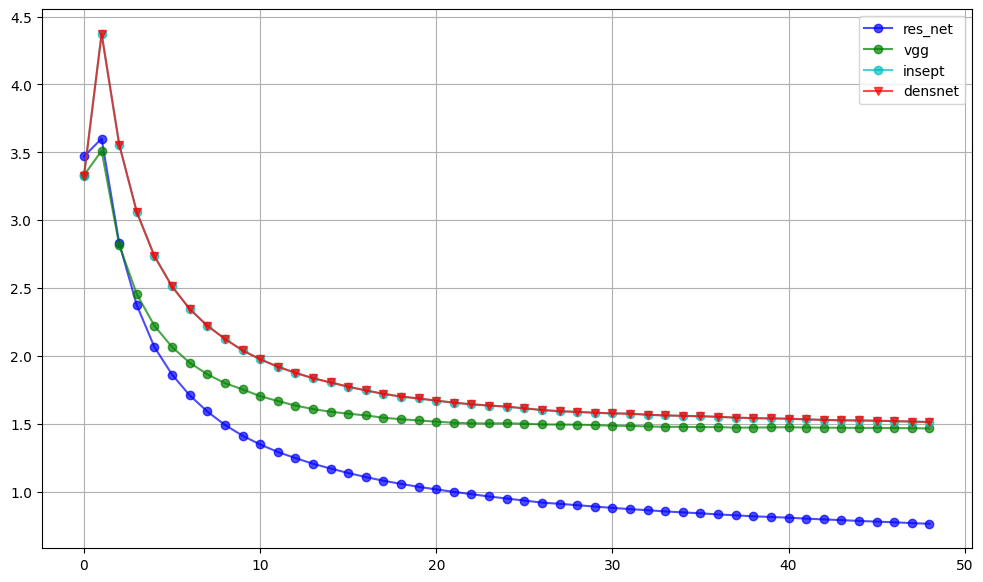

In [135]:
import matplotlib.pyplot as plt
x = list(range(0, len(res_net), 1 ))
plt.figure(figsize=(12, 7))
plt.plot(x, res_net, 'o-b', alpha=0.7, label="res_net", )
plt.plot(x, vgg, 'o-g', alpha=0.7, label="vgg", )
plt.plot(x, insept, 'o-c', alpha=0.7, label="insept")
plt.plot(x, insept, 'v-r', alpha=0.7, label="densnet")
plt.legend()
plt.grid(True)
plt.show()